In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score
)

In [2]:
from sklearn import set_config
set_config(display="diagram")

In [3]:
# Load dataset

data_path = "../datasets/wine_development(in).csv"
df = pd.read_csv(data_path)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
0,5.8,0.31,0.32,4.5,0.024,28.0,94.0,0.98906,3.25,0.52,13.7,7,white,1198
1,6.3,0.13,0.42,1.1,0.043,63.0,146.0,0.99066,3.13,0.72,11.2,7,white,3409
2,8.2,0.30,0.44,12.4,0.043,52.0,154.0,0.99452,3.04,0.33,12.0,6,white,4789
3,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white,3054
4,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.8,8,white,2812


## 1. Data Preperation

In [4]:
# Number of missing values per column
missing_values = df.isna().sum()

missing_values

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
wine_id                 0
dtype: int64

In [5]:
# drop wine id since it is only a technical key and does not provide any meaning to the training of the model.

df = df.drop(columns=["wine_id"])

In [6]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

numeric_columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### 1.2 Check for balance/imbalance of class labels

In [7]:
target = "color"
class_counts = df[target].value_counts()
class_counts


color
white    3134
red      1023
Name: count, dtype: int64

In [8]:
class_percentages = df[target].value_counts(normalize=True) * 100
class_percentages

color
white    75.390907
red      24.609093
Name: proportion, dtype: float64

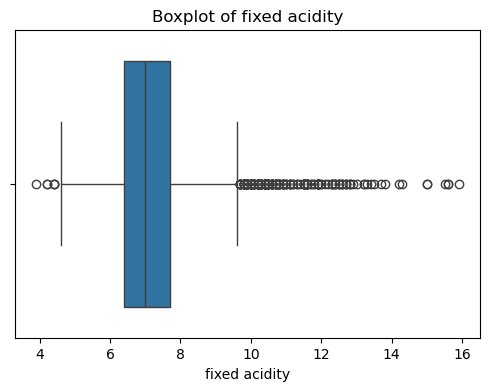

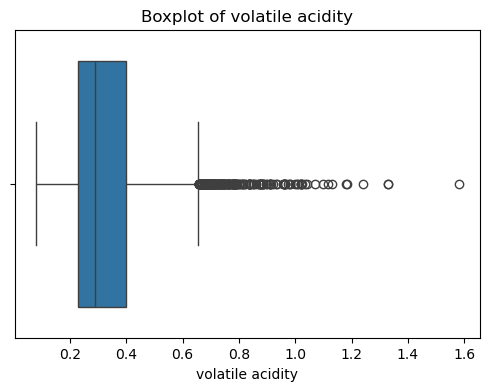

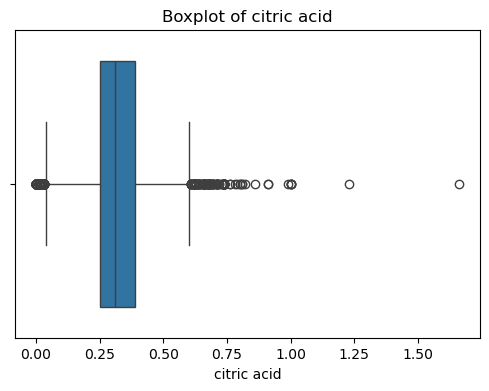

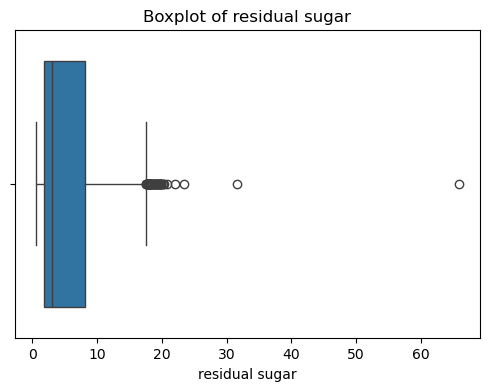

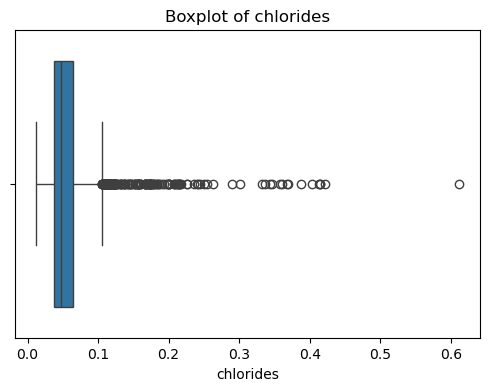

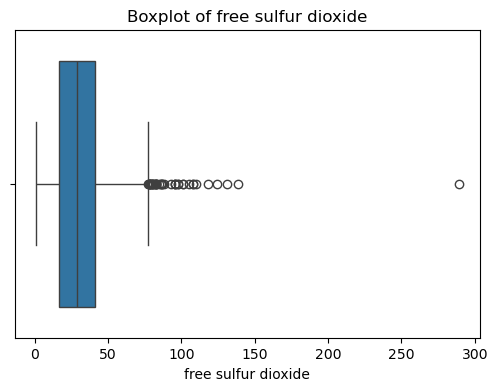

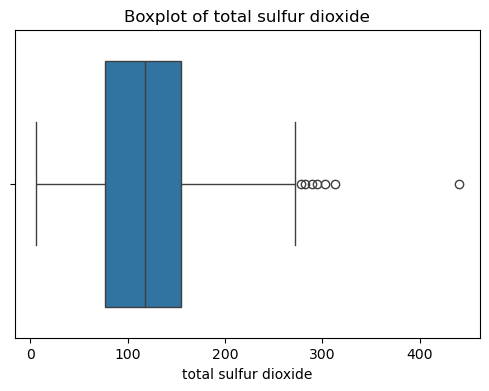

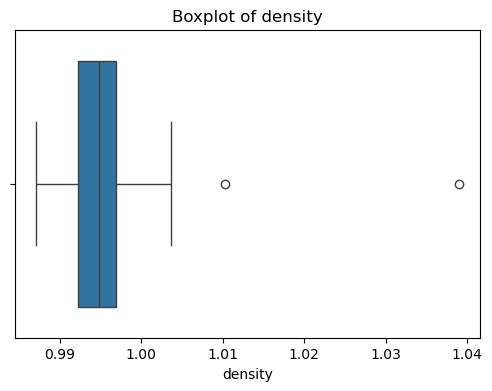

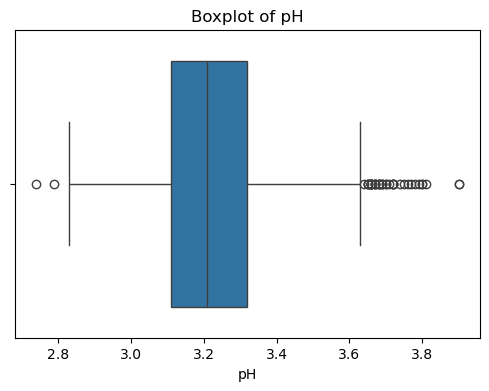

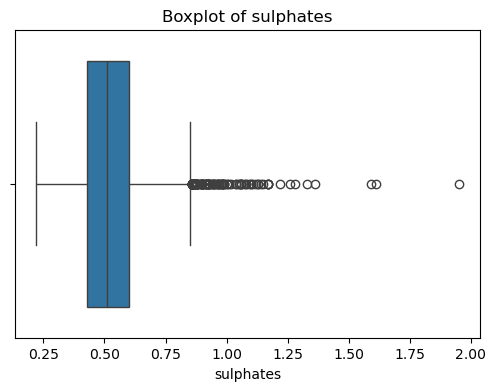

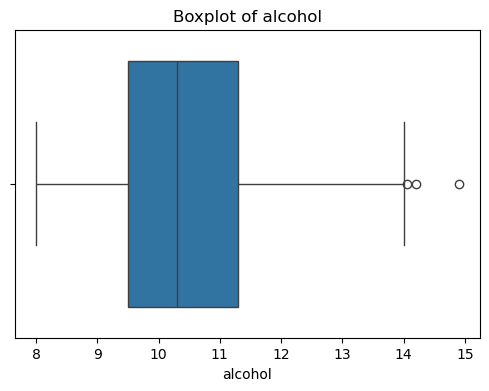

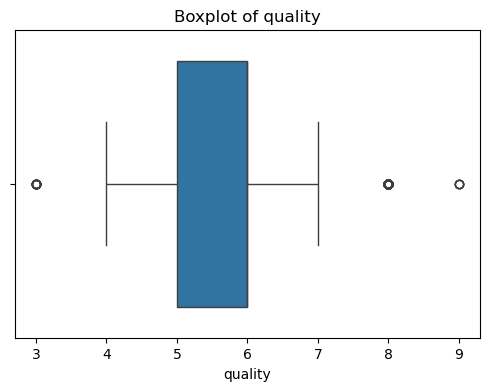

In [9]:

# Boxplots for each numeric variable

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

### 1.3 Train-Test Split

In [10]:
# Split into features (X) and target (y)

target = "color"

X = df.drop(columns=[target])
y = df[target]

# Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keep class proportions
)

# Quick check: shapes
X_train.shape, X_test.shape


((3325, 12), (832, 12))

In [11]:
# Check class proportions in full / train / test


# Full dataset proportions
full_props = y.value_counts(normalize=True)

# Train set proportions
train_props = y_train.value_counts(normalize=True)

# Test set proportions
test_props = y_test.value_counts(normalize=True)

# Combine into one table
class_distribution_check = pd.DataFrame({
    "full": full_props,
    "train": train_props,
    "test": test_props
}).fillna(0)

# Show as percentages
(class_distribution_check * 100).round(2)

,full,train,test
color,,,
white,75.39,75.4,75.36
red,24.61,24.6,24.64


## 2. Model Building with Pipeline

I will build a Pipeline that included a cross validation scheme and hyperparameter tuning using GridSearchCV

### 2.1 Null Model

In [12]:

# Determine majority class from training data

majority_class = y_train.value_counts().idxmax()
majority_class



'white'

In [13]:

# Null model predictions (always predict majority class)

y_pred_null = np.full(shape=y_test.shape, fill_value=majority_class)


In [14]:

# Null model accuracy

null_accuracy = accuracy_score(y_test, y_pred_null)
null_accuracy


0.7536057692307693

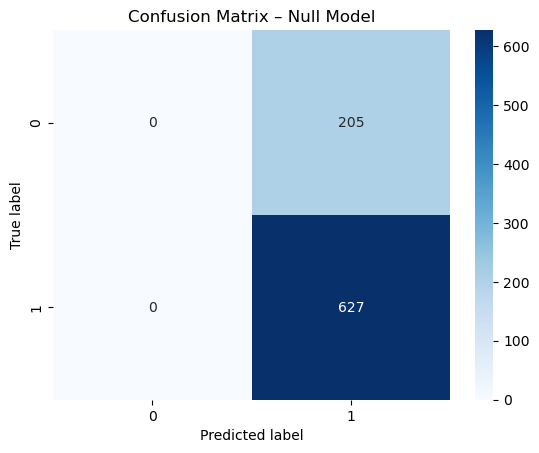

In [15]:
# Confusion matrix for null model

cm_null = confusion_matrix(y_test, y_pred_null)

sns.heatmap(cm_null, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Null Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [16]:
print(classification_report(y_test, y_pred_null))


              precision    recall  f1-score   support

         red       0.00      0.00      0.00       205
       white       0.75      1.00      0.86       627

    accuracy                           0.75       832
   macro avg       0.38      0.50      0.43       832
weighted avg       0.57      0.75      0.65       832



c:\Users\Daniel3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel3\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 2.2 Pipeline with SVM and Hyperparameter Tuning

In [17]:
# cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline configuration



pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

param_grid = [
    # Linear SVM
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__class_weight": [None, "balanced"]
    },
    # RBF (Gaussian) SVM
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.1, 1],
        "svm__class_weight": [None, "balanced"]
    },
    # Polynomial SVM
    {
        "svm__kernel": ["poly"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__degree": [2, 3, 4],
        "svm__coef0": [0, 1],
        "svm__gamma": ["scale"],  # stabiler Start; optional erweitern
        "svm__class_weight": [None, "balanced"]
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={
        "f1": "f1_macro",
        "accuracy": "accuracy",
        "precision": "precision_macro",
        "recall": "recall_macro",
    },          # binär: F1 für positive Klasse; ggf. anpassen
    cv=cv,
    n_jobs=-1,
    refit="f1",            # nach der Suche bestes Modell auf ganz X_train fitten
    verbose=1
)


## 3. Model Training

In [18]:
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (mean F1):", grid.best_score_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
Best params: {'svm__C': 1, 'svm__class_weight': None, 'svm__coef0': 1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best CV score (mean F1): 0.9943093677927208


The best performing model was a polynomial SVM with degree 2. This indicates that wine color is not linearly separable in the original feature space, but becomes almost perfectly separable when quadratic feature interactions are considered. This suggests that interactions between chemical properties (e.g. alcohol × acidity, sugar × density) are decisive for distinguishing red and white wines.

In [19]:
results = pd.DataFrame(grid.cv_results_)

cols = [
    "mean_test_f1",
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "param_svm__kernel",
    "param_svm__C",
    "param_svm__gamma",
    "param_svm__degree",
    "param_svm__coef0",
    "param_svm__class_weight",
]

results = results[cols]

best_per_kernel = (
    results
    .sort_values("mean_test_f1", ascending=False)
    .groupby("param_svm__kernel")
    .head(1)
)

print(best_per_kernel)

    mean_test_f1  mean_test_accuracy  mean_test_precision  mean_test_recall  \
55      0.994309            0.995789             0.995970          0.992686   
37      0.993906            0.995489             0.995355          0.992483   
2       0.992283            0.994286             0.992904          0.991686   

   param_svm__kernel  param_svm__C param_svm__gamma  param_svm__degree  \
55              poly           1.0            scale                2.0   
37               rbf         100.0             0.01                NaN   
2             linear           1.0              NaN                NaN   

    param_svm__coef0 param_svm__class_weight  
55               1.0                    None  
37               NaN                balanced  
2                NaN                    None  


In [20]:
# Evaluierung des besten Models auf Testdaten (Polynomial SVM)

y_pred = grid.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred, pos_label="red"))  # pos_label ggf. prüfen
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

best_model = grid.best_estimator_

grid.best_params_


Test Accuracy: 0.9963942307692307
Test F1: 0.9926650366748166

Confusion matrix:
 [[203   2]
 [  1 626]]

Classification report:
               precision    recall  f1-score   support

         red       1.00      0.99      0.99       205
       white       1.00      1.00      1.00       627

    accuracy                           1.00       832
   macro avg       1.00      0.99      1.00       832
weighted avg       1.00      1.00      1.00       832



{'svm__C': 1,
 'svm__class_weight': None,
 'svm__coef0': 1,
 'svm__degree': 2,
 'svm__gamma': 'scale',
 'svm__kernel': 'poly'}

In [21]:
# Fit model for best RBF, Linear and polynomial SVM for comparison

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Linear SVM
pipe_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="linear",
        C=1,
        class_weight=None
    ))
])

# RBF SVM
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=100,
        gamma=0.01,
        class_weight="balanced"
    ))
])

# Polynomial SVM
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="poly",
        C=1,
        degree=2,
        coef0=1,
        gamma="scale",
        class_weight=None
    ))
])

# Fit
pipe_linear.fit(X_train, y_train)
pipe_rbf.fit(X_train, y_train)
pipe_poly.fit(X_train, y_train)

# Predict
y_pred_linear = pipe_linear.predict(X_test)
y_pred_rbf    = pipe_rbf.predict(X_test)
y_pred_poly   = pipe_poly.predict(X_test)


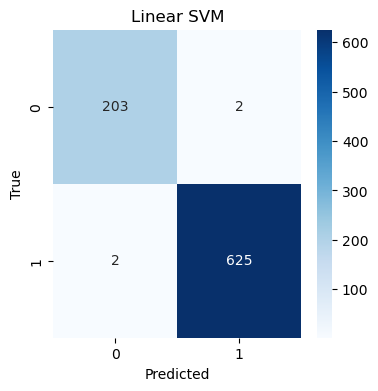

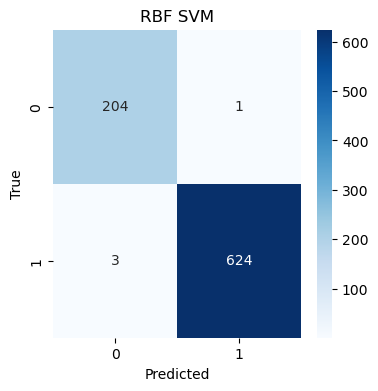

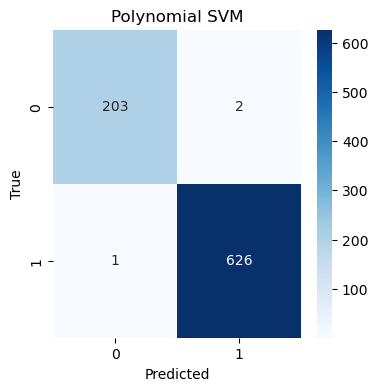

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Linear SVM
cm_linear = confusion_matrix(y_test, y_pred_linear)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_linear, annot=True, fmt="d", cmap="Blues")
plt.title("Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# RBF SVM
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap="Blues")
plt.title("RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Polynomial SVM
cm_poly = confusion_matrix(y_test, y_pred_poly)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_poly, annot=True, fmt="d", cmap="Blues")
plt.title("Polynomial SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Bonus Task

In [24]:
# Load dataset

data_path = "../datasets/wine_development(in).csv"
df = pd.read_csv(data_path)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
0,5.8,0.31,0.32,4.5,0.024,28.0,94.0,0.98906,3.25,0.52,13.7,7,white,1198
1,6.3,0.13,0.42,1.1,0.043,63.0,146.0,0.99066,3.13,0.72,11.2,7,white,3409
2,8.2,0.30,0.44,12.4,0.043,52.0,154.0,0.99452,3.04,0.33,12.0,6,white,4789
3,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white,3054
4,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.8,8,white,2812


In [25]:
# Create binary target variable
# 1 = Excellent wine (quality >= 6)
# 0 = Not excellent wine (quality < 6)

y_excellent = (df["quality"] >= 6).astype(int)

In [26]:
# Remove target columns
X_excellent = df.drop(columns=["quality", "color"], errors="ignore")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_excellent,
    y_excellent,
    test_size=0.2,
    random_state=42,
    stratify=y_excellent
)

In [28]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
svm_poly_excellent = SVC(
    kernel="poly",
    degree=3,
    C=1.0,
    random_state=42
)

svm_poly_excellent.fit(X_train_scaled, y_train)


SVC(kernel='poly', random_state=42)

In [30]:
y_pred = svm_poly_excellent.predict(X_test_scaled)


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7548076923076923

Confusion Matrix:
[[153 151]
 [ 53 475]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.50      0.60       304
           1       0.76      0.90      0.82       528

    accuracy                           0.75       832
   macro avg       0.75      0.70      0.71       832
weighted avg       0.75      0.75      0.74       832



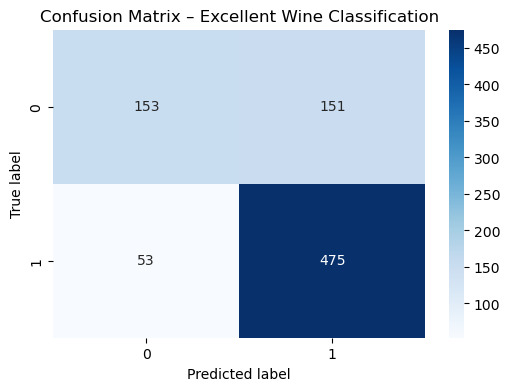

In [32]:

# Confusion matrix (visualization)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)

plt.title("Confusion Matrix – Excellent Wine Classification")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
